## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_fourier_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/fourier/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 12760 CDFs


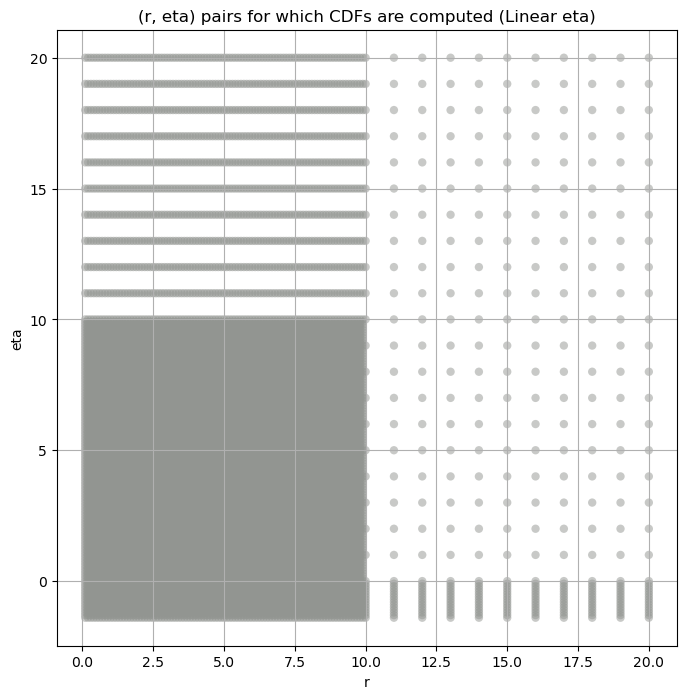

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:25<00:00, 3928.43it/s]


Band 5


100%|██████████| 100000/100000 [00:24<00:00, 4072.35it/s]


Band 8


100%|██████████| 100000/100000 [00:24<00:00, 4084.28it/s]


Band 11


100%|██████████| 100000/100000 [00:24<00:00, 4067.92it/s]


Band 14


100%|██████████| 100000/100000 [00:24<00:00, 4098.14it/s]


Band 17


100%|██████████| 100000/100000 [00:24<00:00, 4088.22it/s]


Band 20


100%|██████████| 100000/100000 [00:24<00:00, 4077.79it/s]


Band 23


100%|██████████| 100000/100000 [00:24<00:00, 4083.23it/s]


obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1477.698100  1373.122700  1589.910200    6.120176    4.479359   
5      613.399660   560.564640   673.379900   10.624530    6.559845   
8      177.002720   161.604260   194.477400   10.694184    6.562629   
11      42.975640    39.382267    46.911724    9.706752    6.305946   
14      12.346855    11.270123    13.649725   11.606633    6.602531   
17       3.035616     2.715409     3.793729   39.583656    7.279816   
20       0.497308     0.429553     0.781897  156.664100    7.438475   
23       0.120288     0.109068     0.150540   34.890343    5.196195   

      kurt_upper  total_samples  
band                             
2       8.864679        47614.0  
5      16.423002       102030.0  
8      22.191257       326496.0  
11     16.889559       904666.0  
14     31.444622      2727602.0  
17    243.687730      8298440.0  
20    791.245600     25140192.0  
23    215.311260     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1477.698100    1477.698120     1406.774048     1361.868896   
5      613.399660     613.399658      585.709900      570.308960   
8      177.002720     177.002716      169.352921      165.065399   
11      42.975640      42.975639       41.237297       40.267872   
14      12.346855      12.346855       11.819737       11.537405   
17       3.035616       3.035616        2.845957        2.771728   
20       0.497308       0.497308        0.449234        0.436986   
23       0.120288       0.120288        0.114054        0.111735   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1325.139526      1293.183228      1239.160645      1194.093994   
5         558.087036       547.547119       530.379944       516.014954   
8         161.667938       158.766647       153.820923       149.617264   
11         39.481876        38.798065        37.631165        36.640366   
14         11.308205        11.109534        10.768895        10.477353   
17          2.712462         2.661526         2.574728         2.501194   
20          0.427366         0.419161         0.405340         0.393703   
23          0.109815         0.108129         0.105202         0.102670   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2         1155.426636      1120.982300      1090.145020      1012.433838  
5          503.584534       492.488373       482.357513       456.235718  
8          145.940216       142.655106       139.662674       131.933701  
11          35.764786        34.973137        34.245052        32.351894  
14          10.219761         9.986947         9.773088         9.217308  
17           2.436600         2.378536         2.325550         2.188769  
20           0.383501         0.374350         0.366008         0.344482  
23           0.100409         0.098352         0.096457         0.091487

####
Band  2


100%|██████████| 12760/12760 [00:22<00:00, 567.87it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.008113968042752384 1477.6981


100%|██████████| 12760/12760 [00:20<00:00, 609.14it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.00827739937785854 1406.774


100%|██████████| 12760/12760 [00:20<00:00, 616.46it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.007805225095464996 1361.8689


100%|██████████| 12760/12760 [00:20<00:00, 612.25it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.00716506859689095 1325.1395


100%|██████████| 12760/12760 [00:21<00:00, 607.10it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.006656409251354634 1293.1832


100%|██████████| 12760/12760 [00:20<00:00, 618.05it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.006672411255586486 1239.1606


100%|██████████| 12760/12760 [00:20<00:00, 611.55it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.006788895007025175 1194.094


100%|██████████| 12760/12760 [00:20<00:00, 615.28it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.00778567102351424 1155.4266


100%|██████████| 12760/12760 [00:20<00:00, 619.94it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.00874789858142111 1120.9823


100%|██████████| 12760/12760 [00:20<00:00, 614.48it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.00956946166090189 1090.145


100%|██████████| 12760/12760 [00:20<00:00, 614.07it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.013080977826294249 1012.43384
Number of samples: 47614, Without approximation : 47614.0


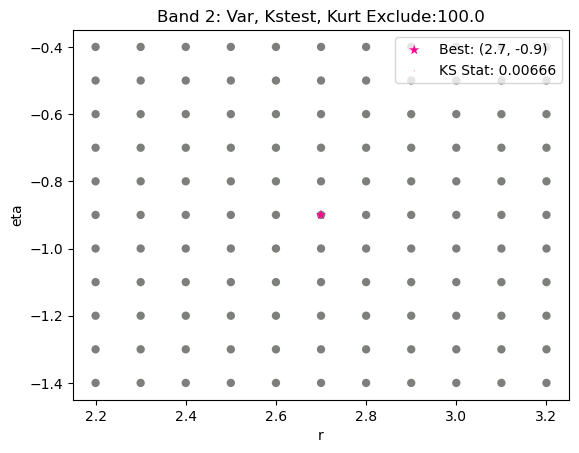

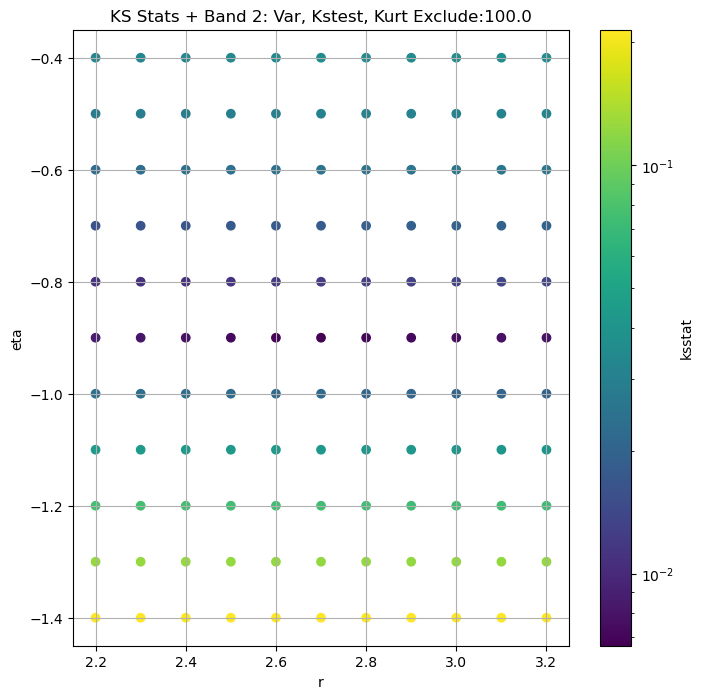

####
Band  5


100%|██████████| 12760/12760 [00:43<00:00, 291.18it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.010291199589617661 613.39966


100%|██████████| 12760/12760 [00:44<00:00, 289.32it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.009591040652239535 585.7099


100%|██████████| 12760/12760 [00:44<00:00, 289.75it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.009347617616351833 570.30896


100%|██████████| 12760/12760 [00:44<00:00, 289.72it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.009899810268402032 558.08704


100%|██████████| 12760/12760 [00:43<00:00, 292.11it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.00925636657668065 547.5471


100%|██████████| 12760/12760 [00:43<00:00, 292.45it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.008387250872999338 530.37994


100%|██████████| 12760/12760 [00:43<00:00, 291.14it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.008012603985624644 516.01495


100%|██████████| 12760/12760 [00:43<00:00, 291.38it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.008093603085956524 503.58453


100%|██████████| 12760/12760 [00:44<00:00, 289.15it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.008149296120980254 492.48837


100%|██████████| 12760/12760 [00:43<00:00, 292.69it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.008182913458892827 482.3575


100%|██████████| 12760/12760 [00:43<00:00, 291.77it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008189096771287652 456.23572
Number of samples: 100000, Without approximation : 102030.0


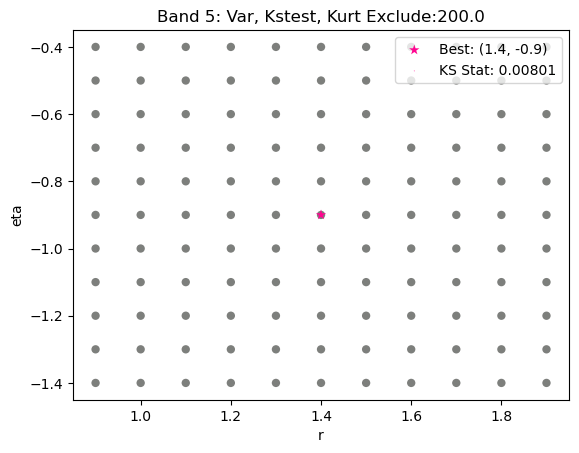

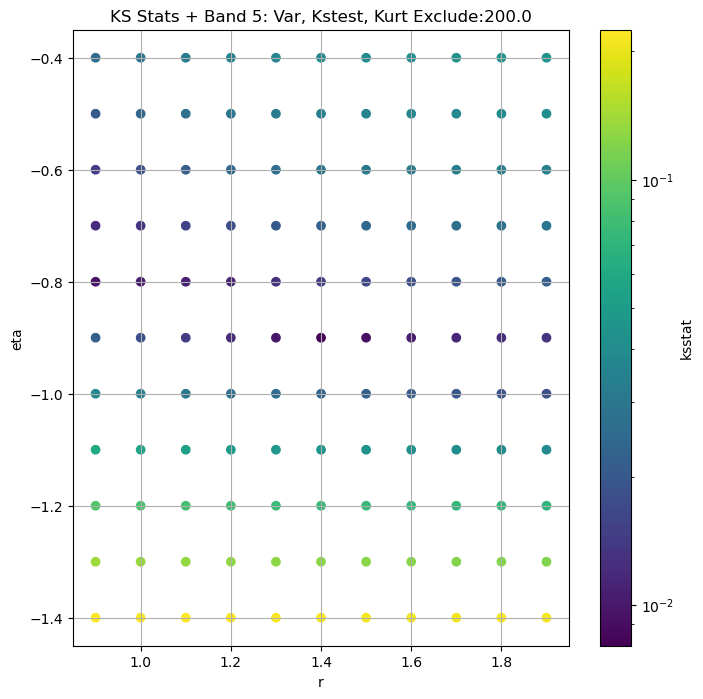

####
Band  8


100%|██████████| 12760/12760 [00:43<00:00, 291.88it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.009652415377184642 177.00272


100%|██████████| 12760/12760 [00:44<00:00, 288.96it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.008975587037850175 169.35292


100%|██████████| 12760/12760 [00:43<00:00, 292.29it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.009121474195004309 165.0654


100%|██████████| 12760/12760 [00:43<00:00, 292.70it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.008661145982333363 161.66794


100%|██████████| 12760/12760 [00:43<00:00, 293.20it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.00852049683091849 158.76665


100%|██████████| 12760/12760 [00:43<00:00, 291.07it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.008271949300760473 153.82092


100%|██████████| 12760/12760 [00:44<00:00, 287.95it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.00803166162418012 149.61726


100%|██████████| 12760/12760 [00:44<00:00, 286.85it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.007981704420380598 145.94022


100%|██████████| 12760/12760 [00:44<00:00, 289.44it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007690692743992145 142.6551


100%|██████████| 12760/12760 [00:43<00:00, 291.89it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.007033498410285943 139.66267


100%|██████████| 12760/12760 [00:44<00:00, 288.74it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007974971048713364 131.9337
Number of samples: 100000, Without approximation : 326496.0


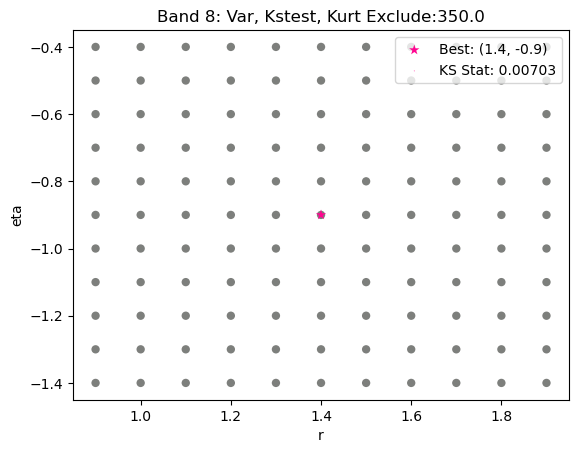

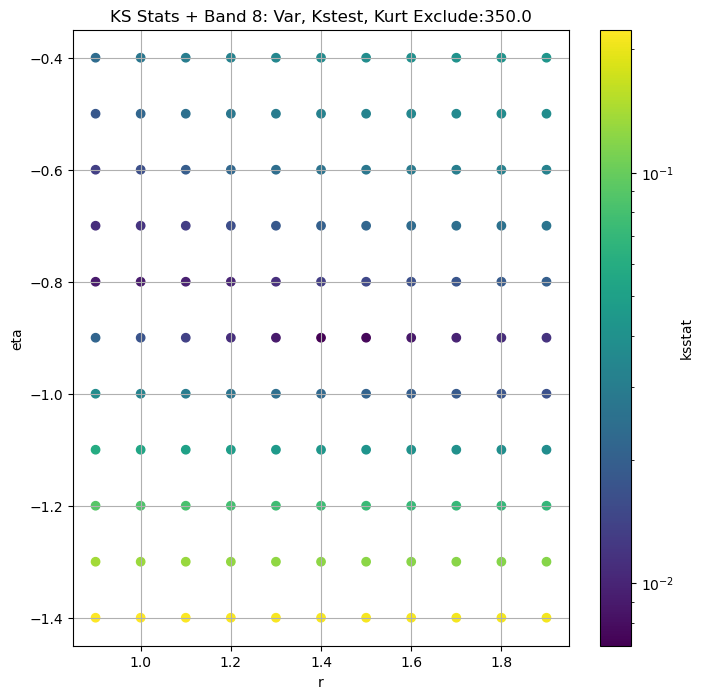

####
Band  11


100%|██████████| 12760/12760 [00:43<00:00, 291.67it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.009218632787955094 42.97564


100%|██████████| 12760/12760 [00:43<00:00, 292.77it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.007211794665137994 41.237297


100%|██████████| 12760/12760 [00:44<00:00, 288.23it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.007723404121643962 40.26787


100%|██████████| 12760/12760 [00:44<00:00, 288.41it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.008299014921219872 39.481876


100%|██████████| 12760/12760 [00:44<00:00, 288.73it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.007936282236375769 38.798065


100%|██████████| 12760/12760 [00:44<00:00, 289.02it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.0076704927203741224 37.631165


100%|██████████| 12760/12760 [00:44<00:00, 288.79it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.007277327120396804 36.640366


100%|██████████| 12760/12760 [00:44<00:00, 286.62it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.006558213629686005 35.764786


100%|██████████| 12760/12760 [00:44<00:00, 287.26it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.006892083557513584 34.973137


100%|██████████| 12760/12760 [00:45<00:00, 277.45it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.006211444969901447 34.245052


100%|██████████| 12760/12760 [00:47<00:00, 266.98it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.00785708365028559 32.351894
Number of samples: 100000, Without approximation : 904666.0


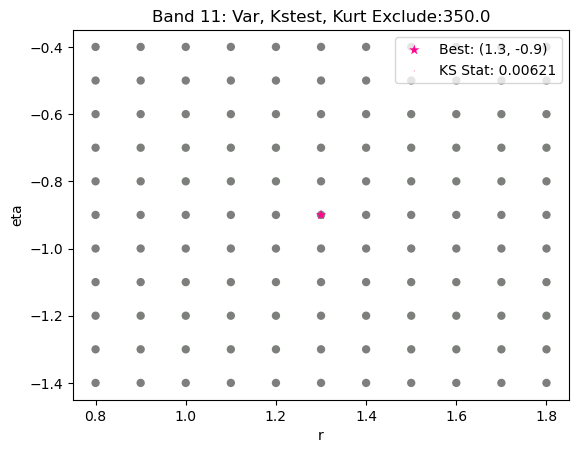

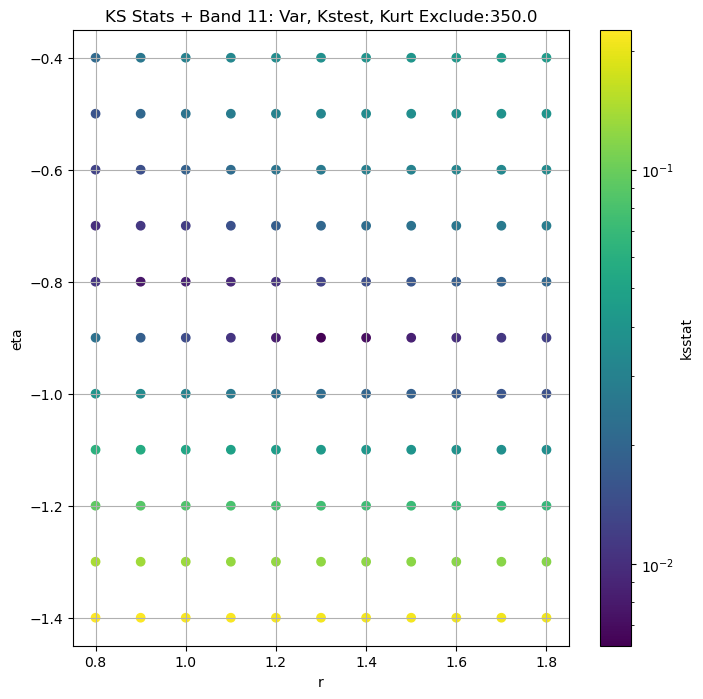

####
Band  14


100%|██████████| 12760/12760 [00:47<00:00, 267.78it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.006320122638976189 12.346855


100%|██████████| 12760/12760 [00:47<00:00, 268.23it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.007532976671114522 11.819737


100%|██████████| 12760/12760 [00:47<00:00, 269.09it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.007742822059590759 11.537405


100%|██████████| 12760/12760 [00:47<00:00, 268.19it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.007886357444144593 11.308205


100%|██████████| 12760/12760 [00:47<00:00, 268.64it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.007052627003324596 11.109534


100%|██████████| 12760/12760 [00:47<00:00, 266.64it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.005578612434871566 10.768895


100%|██████████| 12760/12760 [00:47<00:00, 267.77it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.006841017587228215 10.477353


100%|██████████| 12760/12760 [00:47<00:00, 267.57it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.0063350153812826715 10.219761


100%|██████████| 12760/12760 [00:47<00:00, 268.36it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.006059344907401787 9.986947


100%|██████████| 12760/12760 [00:47<00:00, 268.99it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.0063969609112553005 9.773088


100%|██████████| 12760/12760 [00:47<00:00, 265.84it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.008200628337107996 9.217308
Number of samples: 100000, Without approximation : 2727602.0


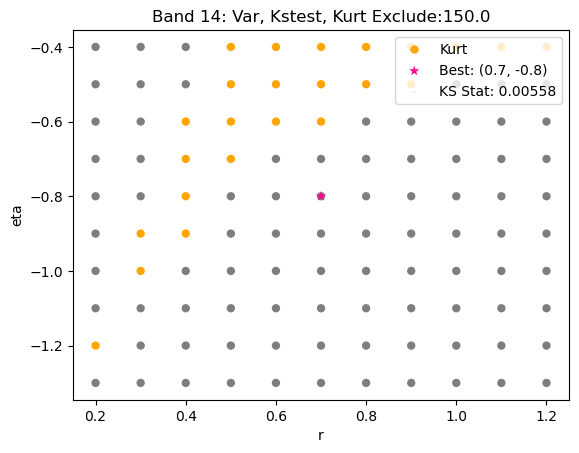

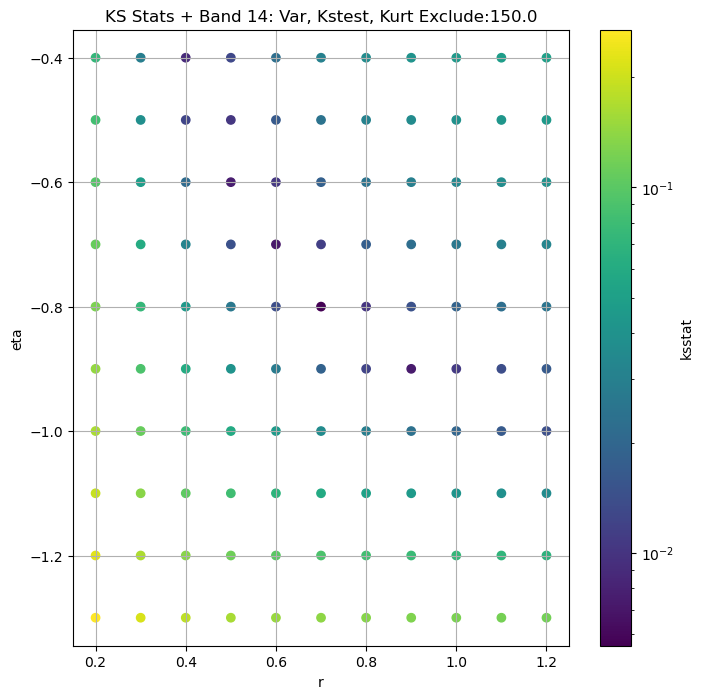

####
Band  17


100%|██████████| 12760/12760 [00:47<00:00, 266.91it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.004582401697251326 3.0356157


100%|██████████| 12760/12760 [00:47<00:00, 267.13it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.005980501881981737 2.8459568


100%|██████████| 12760/12760 [00:46<00:00, 271.55it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.005307394563557444 2.7717276


100%|██████████| 12760/12760 [00:47<00:00, 269.47it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.004871712950959672 2.7124624


100%|██████████| 12760/12760 [00:47<00:00, 269.83it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.004287753375240899 2.661526


100%|██████████| 12760/12760 [00:47<00:00, 267.54it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.004642242754986148 2.5747275


100%|██████████| 12760/12760 [00:47<00:00, 266.52it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.005701914837959676 2.5011945


100%|██████████| 12760/12760 [00:47<00:00, 268.08it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.005462358268121137 2.4366002


100%|██████████| 12760/12760 [00:47<00:00, 267.86it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.005655402110145258 2.378536


100%|██████████| 12760/12760 [00:47<00:00, 270.78it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.00650955531393671 2.3255498


100%|██████████| 12760/12760 [00:46<00:00, 276.81it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.007971390712970372 2.1887686
Number of samples: 100000, Without approximation : 8298440.0


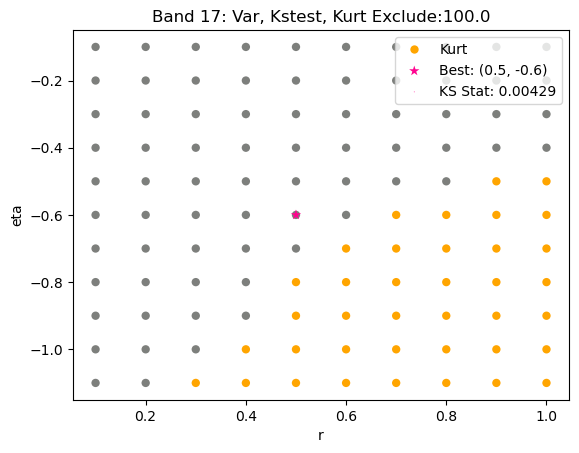

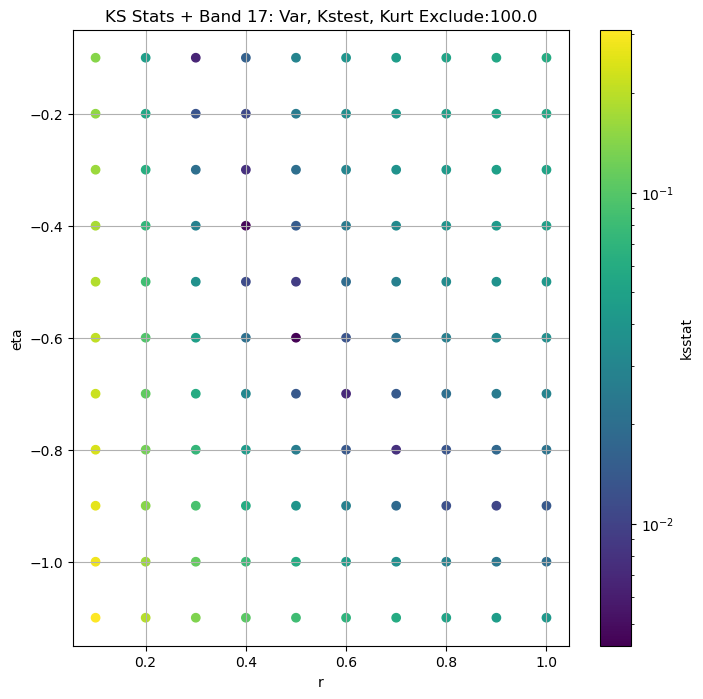

####
Band  20


100%|██████████| 12760/12760 [00:45<00:00, 279.13it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.003353786254216118 0.49730793


100%|██████████| 12760/12760 [00:47<00:00, 268.93it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.0024526607871093453 0.4492336


100%|██████████| 12760/12760 [00:46<00:00, 276.43it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.002580622682672895 0.43698645


100%|██████████| 12760/12760 [00:45<00:00, 277.91it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.0031722542802096187 0.42736554


100%|██████████| 12760/12760 [00:46<00:00, 275.90it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.0032515667833028505 0.41916057


100%|██████████| 12760/12760 [00:45<00:00, 278.11it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.004212312357727788 0.40534046


100%|██████████| 12760/12760 [00:45<00:00, 277.48it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.00470911354678083 0.39370337


100%|██████████| 12760/12760 [00:45<00:00, 277.44it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.0052802262841533665 0.3835014


100%|██████████| 12760/12760 [00:45<00:00, 277.42it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.005946416287400447 0.37435


100%|██████████| 12760/12760 [00:46<00:00, 275.74it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.006370021701405104 0.36600795


100%|██████████| 12760/12760 [00:46<00:00, 275.16it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.008085172545829855 0.34448177
Number of samples: 100000, Without approximation : 25140192.0


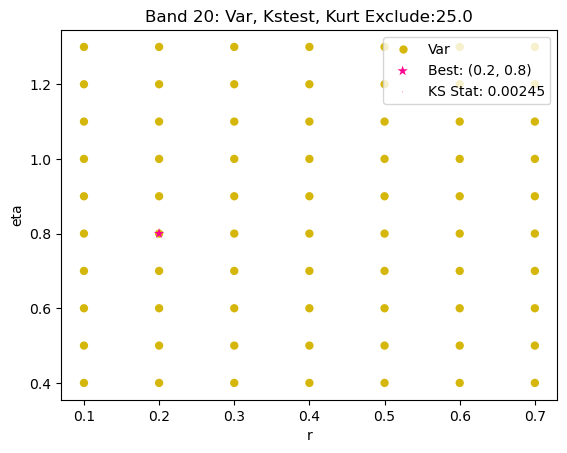

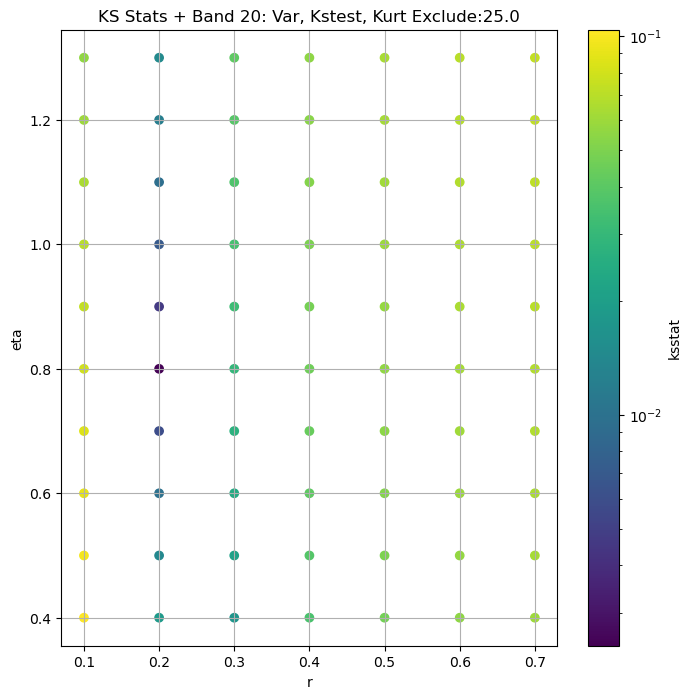

####
Band  23


100%|██████████| 12760/12760 [00:45<00:00, 278.19it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.0030844773052775 0.12028828


100%|██████████| 12760/12760 [00:46<00:00, 277.33it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.002455017693741679 0.114054374


100%|██████████| 12760/12760 [00:45<00:00, 279.22it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.002905406909590985 0.111734785


100%|██████████| 12760/12760 [00:45<00:00, 277.95it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.0031619264674765946 0.10981531


100%|██████████| 12760/12760 [00:45<00:00, 278.08it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.0036272878867471547 0.10812898


100%|██████████| 12760/12760 [00:45<00:00, 279.06it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.004169033821916357 0.10520178


100%|██████████| 12760/12760 [00:45<00:00, 279.70it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.0046081084463788224 0.10266997


100%|██████████| 12760/12760 [00:45<00:00, 279.59it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.005243003599384899 0.100409225


100%|██████████| 12760/12760 [00:46<00:00, 276.98it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.005789999667538903 0.09835236


100%|██████████| 12760/12760 [00:46<00:00, 276.79it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.006494922708103368 0.096456885


100%|██████████| 12760/12760 [00:45<00:00, 279.47it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.008157775789681243 0.091487035
Number of samples: 100000, Without approximation : 65734528.0


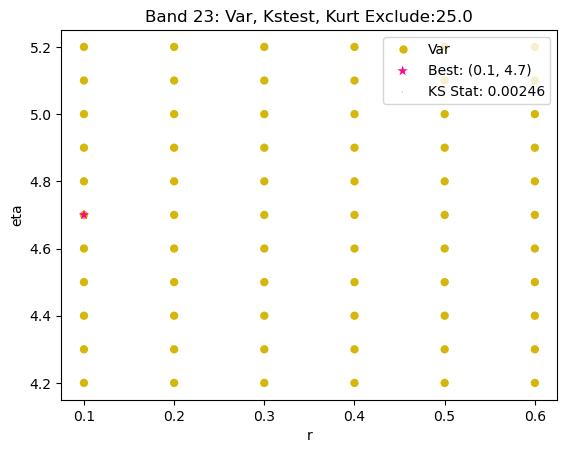

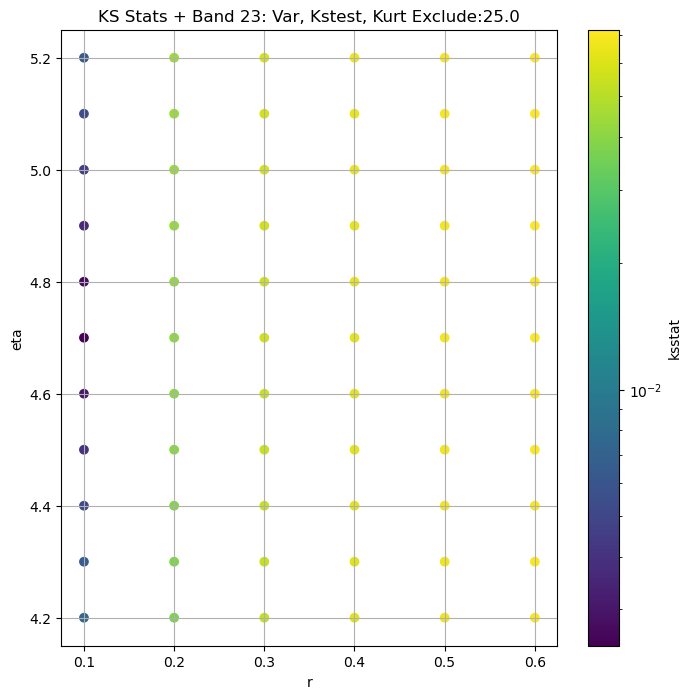

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1477.698100  1373.122700  1589.910200    6.120176    4.479359   
5      613.399660   560.564640   673.379900   10.624530    6.559845   
8      177.002720   161.604260   194.477400   10.694184    6.562629   
11      42.975640    39.382267    46.911724    9.706752    6.305946   
14      12.346855    11.270123    13.649725   11.606633    6.602531   
17       3.035616     2.715409     3.793729   39.583656    7.279816   
20       0.497308     0.429553     0.781897  156.664100    7.438475   
23       0.120288     0.109068     0.150540   34.890343    5.196195   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.864679        47614.0             0.006656        2.7         -0.9   
5      16.423002       102030.0             0.008013        1.4         -0.9   
8      22.191257       326496.0             0.007033        1.4         -0.9   
11     16.889559       904666.0             0.006211        1.3         -0.9   
14     31.444622      2727602.0             0.005579        0.7         -0.8   
17    243.687730      8298440.0             0.004288        0.5         -0.6   
20    791.245600     25140192.0             0.002453        0.2          0.8   
23    215.311260     65734528.0             0.002455        0.1          4.7   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.525249e+03                   100.0         1293.183200   
5      1.140500e+03                   200.0          516.014950   
8      3.086836e+02                   350.0          139.662670   
11     7.216249e+01                   350.0           34.245052   
14     8.507422e+00                   150.0           10.768895   
17     5.280805e-01                   100.0            2.661526   
20     1.029985e-06                    25.0            0.449234   
23     6.806961e-20                    25.0            0.114054   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 180/180 [00:00<00:00, 484.96it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.007471318043493658, var: 1194.093994140625


100%|██████████| 180/180 [00:00<00:00, 579.66it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.007196484360163402, var: 1215.6268310546875


100%|██████████| 180/180 [00:00<00:00, 612.13it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.006914140733785712, var: 1239.16064453125


100%|██████████| 180/180 [00:00<00:00, 583.43it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.006672681378908141, var: 1264.8447265625


100%|██████████| 180/180 [00:00<00:00, 548.88it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.006656409251354634, var: 1293.1832275390625


100%|██████████| 180/180 [00:00<00:00, 553.74it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.00716506859689095, var: 1325.1395263671875


100%|██████████| 180/180 [00:00<00:00, 486.18it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.009436146621872699, var: 1361.868896484375


100%|██████████| 180/180 [00:00<00:00, 507.28it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.011198130776817972, var: 1406.7740478515625


100%|██████████| 180/180 [00:00<00:00, 539.00it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.013608420697778567, var: 1477.6981201171875
Number of samples: 47614, Without approximation : 47614.0


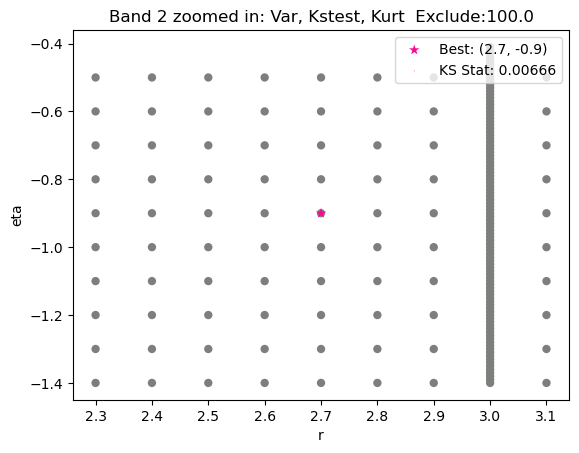

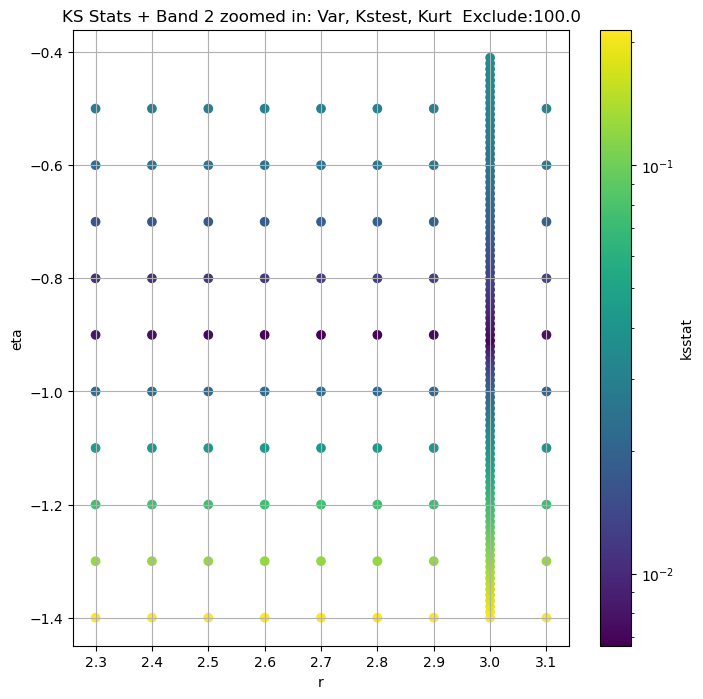

Band 5


100%|██████████| 1900/1900 [00:08<00:00, 235.20it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 100 = 300, ksstat: 0.007885040408050326, var: 492.4883728027344


100%|██████████| 1900/1900 [00:06<00:00, 286.56it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 75 = 275, ksstat: 0.007979025208180557, var: 497.8919372558594


100%|██████████| 1900/1900 [00:06<00:00, 288.00it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 50 = 250, ksstat: 0.007863016199793016, var: 503.58453369140625


100%|██████████| 1900/1900 [00:06<00:00, 284.68it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 25 = 225, ksstat: 0.008027509285823131, var: 509.6221923828125


100%|██████████| 1900/1900 [00:07<00:00, 271.18it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 0 = 200, ksstat: 0.008012603985624644, var: 516.0149536132812


100%|██████████| 1900/1900 [00:06<00:00, 277.58it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -25 = 175, ksstat: 0.008119504085159157, var: 522.9220581054688


100%|██████████| 1900/1900 [00:06<00:00, 281.57it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -50 = 150, ksstat: 0.008387250872999338, var: 530.3799438476562


100%|██████████| 1900/1900 [00:06<00:00, 283.94it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -75 = 125, ksstat: 0.008433378484671461, var: 538.4407348632812


100%|██████████| 1900/1900 [00:06<00:00, 282.03it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -100 = 100, ksstat: 0.008556095320959023, var: 547.547119140625
Number of samples: 100000, Without approximation : 102030.0


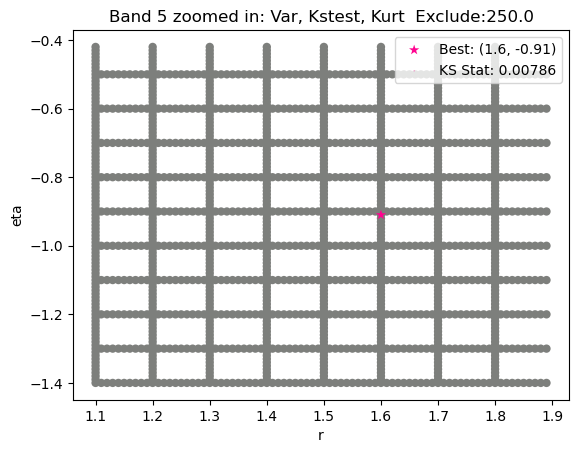

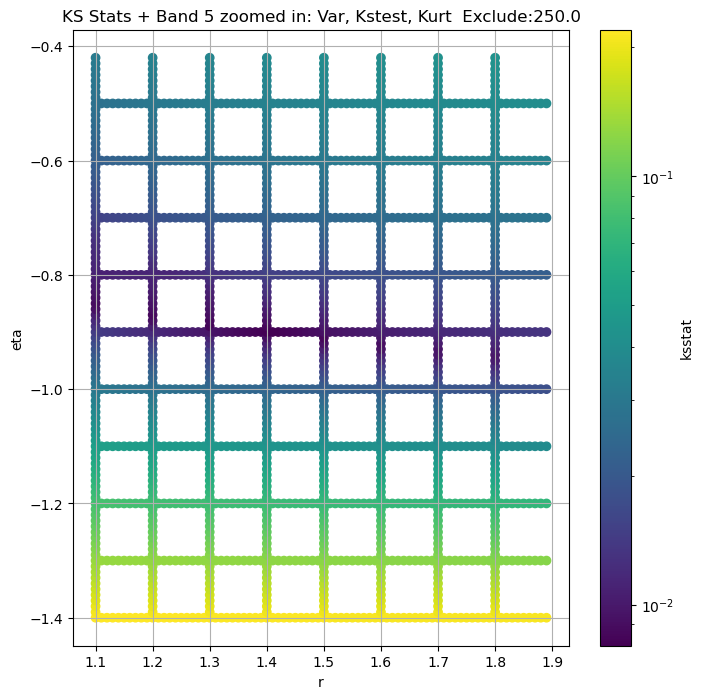

Band 8


100%|██████████| 1900/1900 [00:06<00:00, 282.52it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.007384805684083062, var: 134.3388214111328


100%|██████████| 1900/1900 [00:06<00:00, 284.97it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.007130494711799384, var: 135.59683227539062


100%|██████████| 1900/1900 [00:06<00:00, 287.64it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.006932378278113327, var: 136.89825439453125


100%|██████████| 1900/1900 [00:06<00:00, 286.99it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.007052766759702345, var: 138.25257873535156


100%|██████████| 1900/1900 [00:06<00:00, 286.39it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.006857088543103462, var: 139.6626739501953


100%|██████████| 1900/1900 [00:06<00:00, 288.28it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.007014970015879363, var: 141.1277618408203


100%|██████████| 1900/1900 [00:06<00:00, 286.69it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.007005956664726476, var: 142.6551055908203


100%|██████████| 1900/1900 [00:06<00:00, 292.55it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.007093291860905959, var: 144.25872802734375


100%|██████████| 1900/1900 [00:06<00:00, 290.29it/s]


Finding Minimum after computing 1900 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.0072799682776223396, var: 145.94021606445312
Number of samples: 100000, Without approximation : 326496.0


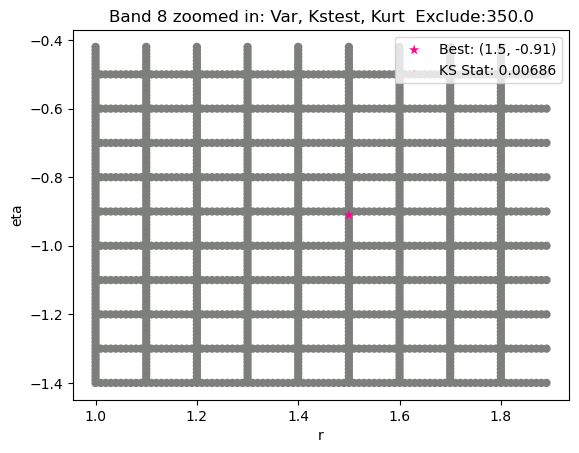

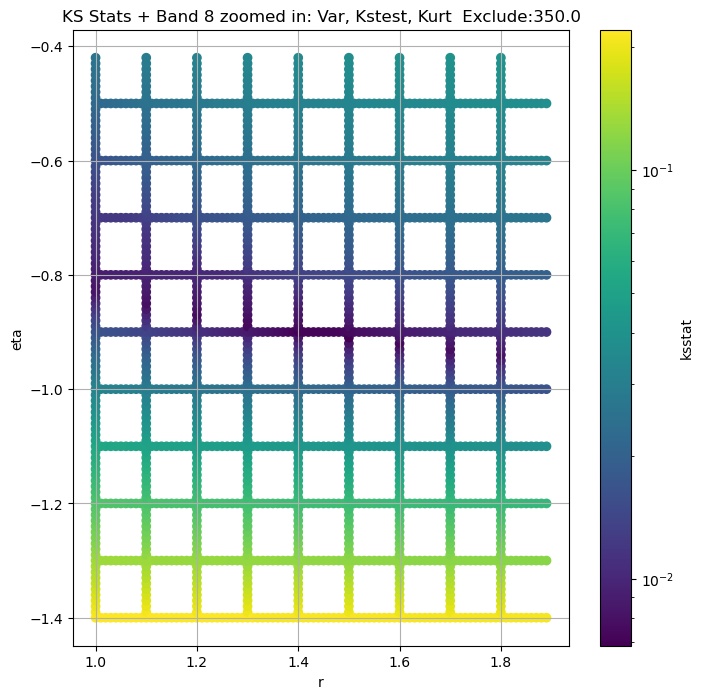

Band 11


100%|██████████| 1800/1800 [00:06<00:00, 284.64it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + 100 = 450, ksstat: 0.007256167423117188, var: 32.942508697509766


100%|██████████| 1800/1800 [00:06<00:00, 288.50it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + 75 = 425, ksstat: 0.006999152336520376, var: 33.25173568725586


100%|██████████| 1800/1800 [00:06<00:00, 288.98it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + 50 = 400, ksstat: 0.006686686643941009, var: 33.57124328613281


100%|██████████| 1800/1800 [00:06<00:00, 289.85it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + 25 = 375, ksstat: 0.006447114375732643, var: 33.90180969238281


100%|██████████| 1800/1800 [00:06<00:00, 290.96it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + 0 = 350, ksstat: 0.006211444969901447, var: 34.245052337646484


100%|██████████| 1800/1800 [00:06<00:00, 289.01it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + -25 = 325, ksstat: 0.0060296036648633256, var: 34.6016845703125


100%|██████████| 1800/1800 [00:06<00:00, 288.98it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + -50 = 300, ksstat: 0.006072972313321934, var: 34.97313690185547


100%|██████████| 1800/1800 [00:06<00:00, 287.75it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + -75 = 275, ksstat: 0.006164617780639481, var: 35.3601188659668


100%|██████████| 1800/1800 [00:06<00:00, 290.20it/s]


Finding Minimum after computing 1800 CDFs
band 11, 350.0 + -100 = 250, ksstat: 0.0063301867373012355, var: 35.76478576660156
Number of samples: 100000, Without approximation : 904666.0


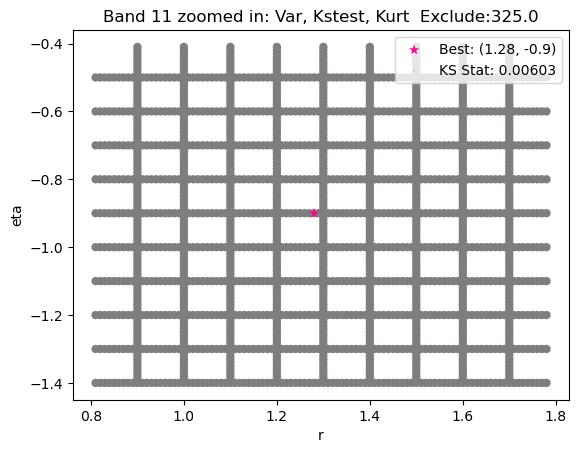

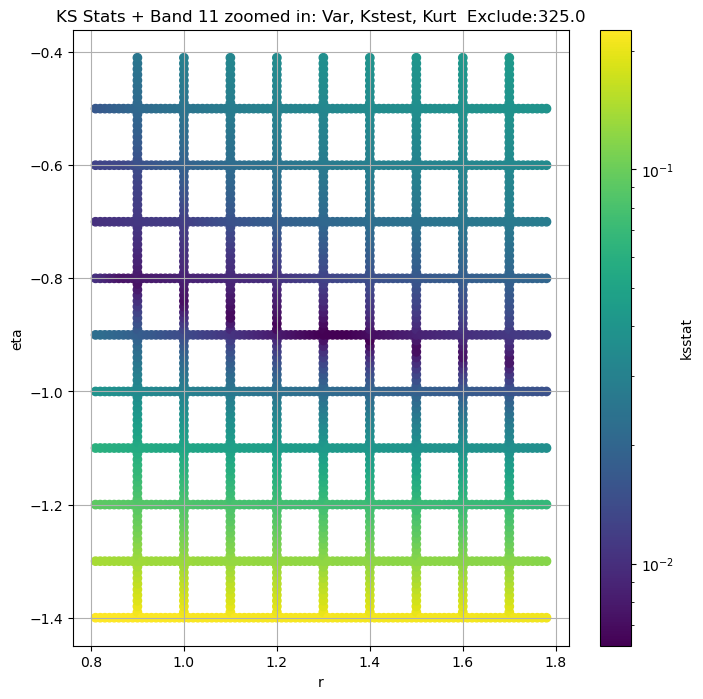

Band 14


100%|██████████| 1800/1800 [00:06<00:00, 270.88it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + 100 = 250, ksstat: 0.005416316071129801, var: 10.21976089477539


100%|██████████| 1800/1800 [00:06<00:00, 288.19it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + 75 = 225, ksstat: 0.005107953151574807, var: 10.344963073730469


100%|██████████| 1800/1800 [00:06<00:00, 291.40it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + 50 = 200, ksstat: 0.005524353232498558, var: 10.4773530960083


100%|██████████| 1800/1800 [00:06<00:00, 290.37it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + 25 = 175, ksstat: 0.00550541714817343, var: 10.618074417114258


100%|██████████| 1800/1800 [00:06<00:00, 291.11it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + 0 = 150, ksstat: 0.005489984681097626, var: 10.768895149230957


100%|██████████| 1800/1800 [00:06<00:00, 289.44it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + -25 = 125, ksstat: 0.005486042307128403, var: 10.931593894958496


100%|██████████| 1800/1800 [00:06<00:00, 287.04it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + -50 = 100, ksstat: 0.005801917680926444, var: 11.10953426361084


100%|██████████| 1800/1800 [00:06<00:00, 271.96it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + -75 = 75, ksstat: 0.0058391503527599475, var: 11.308204650878906


100%|██████████| 1800/1800 [00:06<00:00, 281.07it/s]


Finding Minimum after computing 1800 CDFs
band 14, 150.0 + -100 = 50, ksstat: 0.005749120232116711, var: 11.537405014038086
Number of samples: 100000, Without approximation : 2727602.0


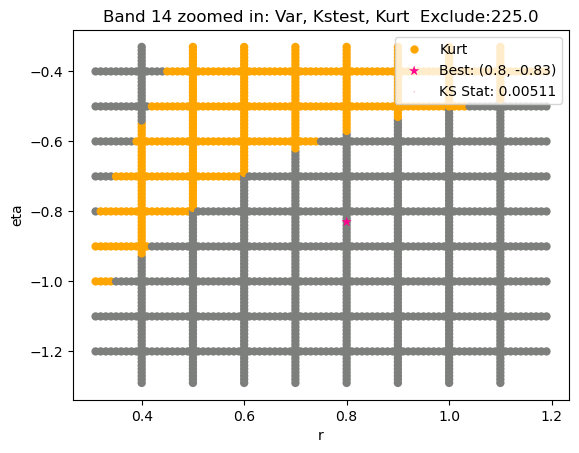

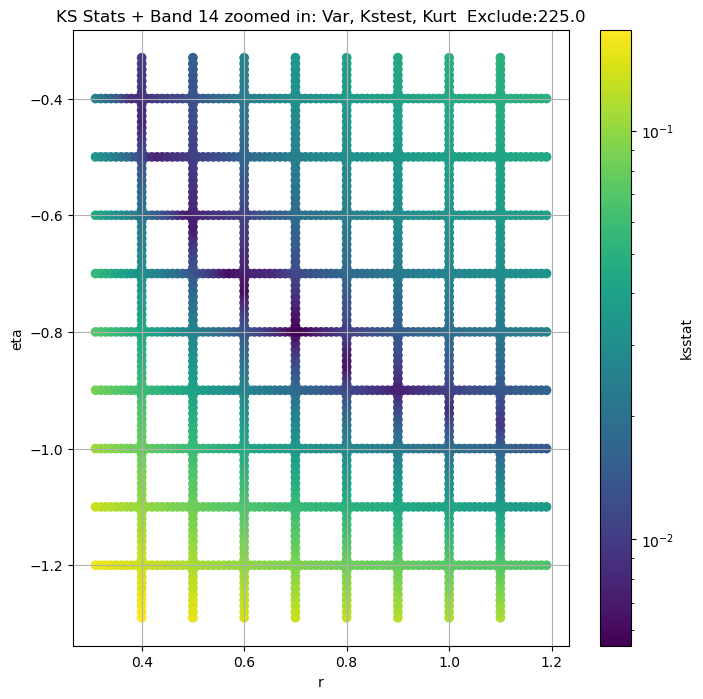

Band 17


100%|██████████| 1692/1692 [00:06<00:00, 275.17it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + 100 = 200, ksstat: 0.004405486341401366, var: 2.501194477081299


100%|██████████| 1692/1692 [00:05<00:00, 286.26it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + 75 = 175, ksstat: 0.00415272016174506, var: 2.5366404056549072


100%|██████████| 1692/1692 [00:06<00:00, 281.53it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + 50 = 150, ksstat: 0.003792803725767735, var: 2.5747275352478027


100%|██████████| 1692/1692 [00:05<00:00, 291.46it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + 25 = 125, ksstat: 0.0035959498849973404, var: 2.6160783767700195


100%|██████████| 1692/1692 [00:05<00:00, 290.48it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + 0 = 100, ksstat: 0.004206446939618913, var: 2.6615259647369385


100%|██████████| 1692/1692 [00:05<00:00, 289.74it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + -25 = 75, ksstat: 0.003982598335430465, var: 2.7124624252319336


100%|██████████| 1692/1692 [00:05<00:00, 292.38it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + -50 = 50, ksstat: 0.004087003348722973, var: 2.7717275619506836


100%|██████████| 1692/1692 [00:05<00:00, 286.61it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + -75 = 25, ksstat: 0.004360391168982902, var: 2.845956802368164


100%|██████████| 1692/1692 [00:05<00:00, 285.66it/s]


Finding Minimum after computing 1692 CDFs
band 17, 100.0 + -100 = 0, ksstat: 0.004582401697251326, var: 3.0356156826019287
Number of samples: 100000, Without approximation : 8298440.0


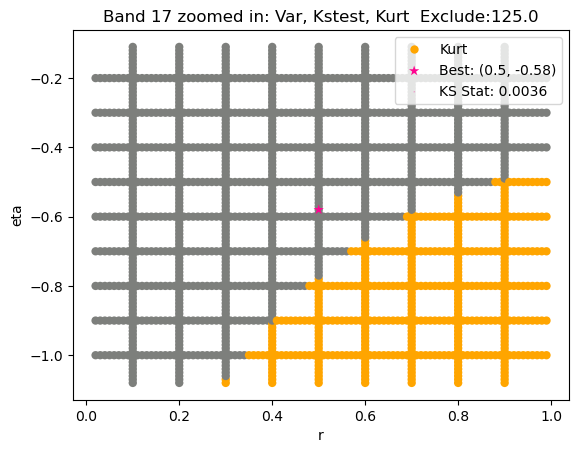

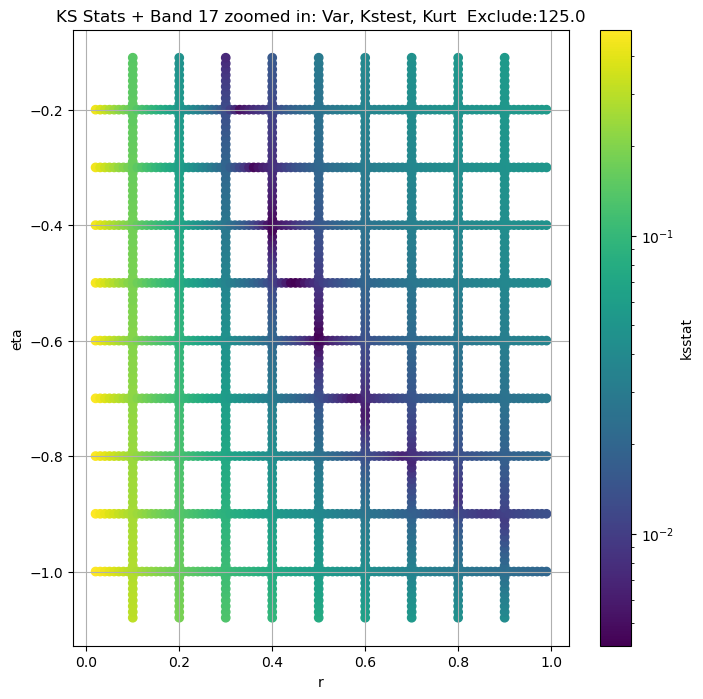

Band 20


100%|██████████| 621/621 [00:02<00:00, 258.21it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.003881009724743145, var: 0.4119047522544861


100%|██████████| 621/621 [00:02<00:00, 290.27it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.003426586122109332, var: 0.4191605746746063


100%|██████████| 621/621 [00:02<00:00, 282.68it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0029371759556433563, var: 0.4273655414581299


100%|██████████| 621/621 [00:02<00:00, 288.98it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.002580622682672895, var: 0.43698644638061523


100%|██████████| 621/621 [00:02<00:00, 286.65it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0024526607871093453, var: 0.4492335915565491


100%|██████████| 621/621 [00:02<00:00, 290.28it/s]


Finding Minimum after computing 621 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.00444044382079023, var: 0.4973079264163971
Number of samples: 100000, Without approximation : 25140192.0


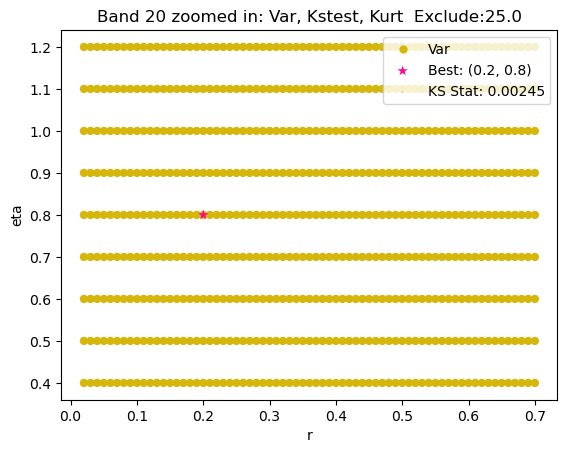

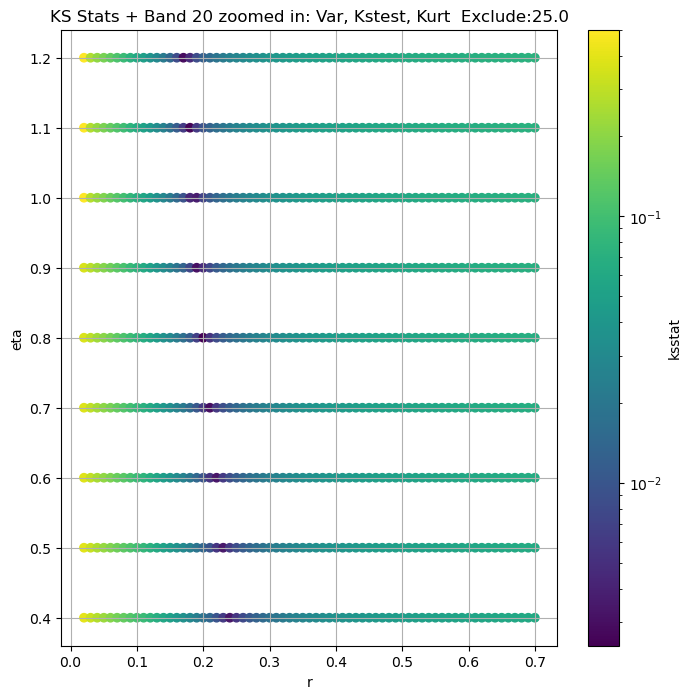

Band 23


100%|██████████| 522/522 [00:02<00:00, 256.46it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.004428489453064177, var: 0.10660441964864731


100%|██████████| 522/522 [00:01<00:00, 264.32it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.004015090185223169, var: 0.10812897980213165


100%|██████████| 522/522 [00:01<00:00, 285.42it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.003531591890431396, var: 0.10981530696153641


100%|██████████| 522/522 [00:01<00:00, 286.92it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.003003096993707932, var: 0.1117347851395607


100%|██████████| 522/522 [00:01<00:00, 287.54it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.002455017693741679, var: 0.114054374396801


100%|██████████| 522/522 [00:01<00:00, 289.73it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0029984762549027377, var: 0.12028828263282776
Number of samples: 100000, Without approximation : 65734528.0


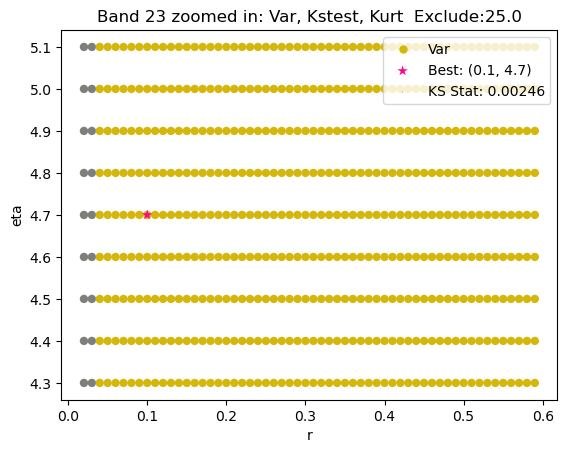

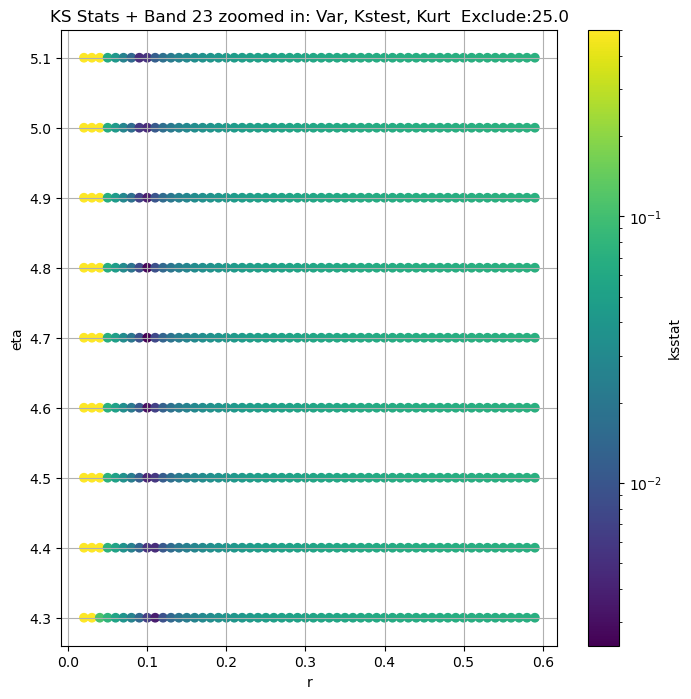

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1477.698100  1373.122700  1589.910200    6.120176    4.479359   
5      613.399660   560.564640   673.379900   10.624530    6.559845   
8      177.002720   161.604260   194.477400   10.694184    6.562629   
11      42.975640    39.382267    46.911724    9.706752    6.305946   
14      12.346855    11.270123    13.649725   11.606633    6.602531   
17       3.035616     2.715409     3.793729   39.583656    7.279816   
20       0.497308     0.429553     0.781897  156.664100    7.438475   
23       0.120288     0.109068     0.150540   34.890343    5.196195   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.864679        47614.0             0.006656        2.7         -0.9   
5      16.423002       102030.0             0.008013        1.4         -0.9   
8      22.191257       326496.0             0.007033        1.4         -0.9   
11     16.889559       904666.0             0.006211        1.3         -0.9   
14     31.444622      2727602.0             0.005579        0.7         -0.8   
17    243.687730      8298440.0             0.004288        0.5         -0.6   
20    791.245600     25140192.0             0.002453        0.2          0.8   
23    215.311260     65734528.0             0.002455        0.1          4.7   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.525249e+03                   100.0         1293.183200   
5      1.140500e+03                   200.0          503.584534   
8      3.086836e+02                   350.0          139.662674   
11     7.216249e+01                   350.0           34.601685   
14     8.507422e+00                   150.0           10.344963   
17     5.280805e-01                   100.0            2.616078   
20     1.029985e-06                    25.0            0.449234   
23     6.806961e-20                    25.0            0.114054   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.006656    2.70     -0.90   
5                    0.004250          0.007863    1.60     -0.91   
8                    0.002376          0.006857    1.50     -0.91   
11                   0.001428          0.006030    1.28     -0.90   
14                   0.000822          0.005108    0.80     -0.83   
17                   0.000471          0.003596    0.50     -0.58   
20                   0.000271          0.002453    0.20      0.80   
23                   0.000168          0.002455    0.10      4.70   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     3.525249e+03                100.0        40173  
5     1.210222e+03                250.0        28695  
8     3.253503e+02                350.0        40812  
11    7.212481e+01                325.0        53667  
14    1.118454e+01                225.0        71917  
17    5.006274e-01                125.0       145870  
20    1.029985e-06                 25.0       294610  
23    6.806961e-20                 25.0       308472

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

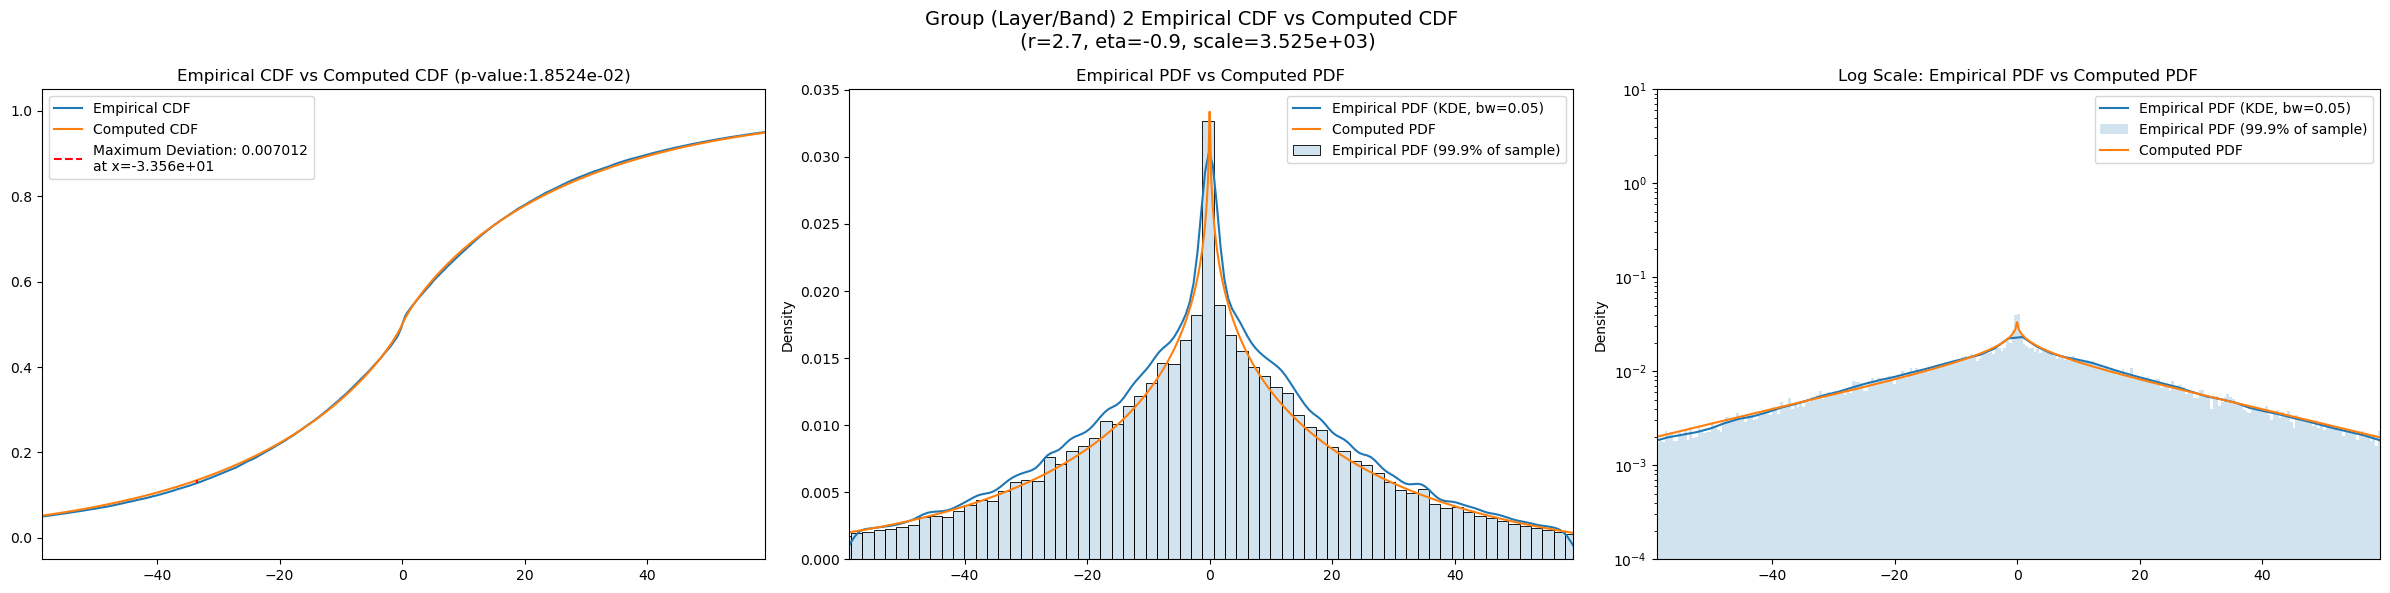

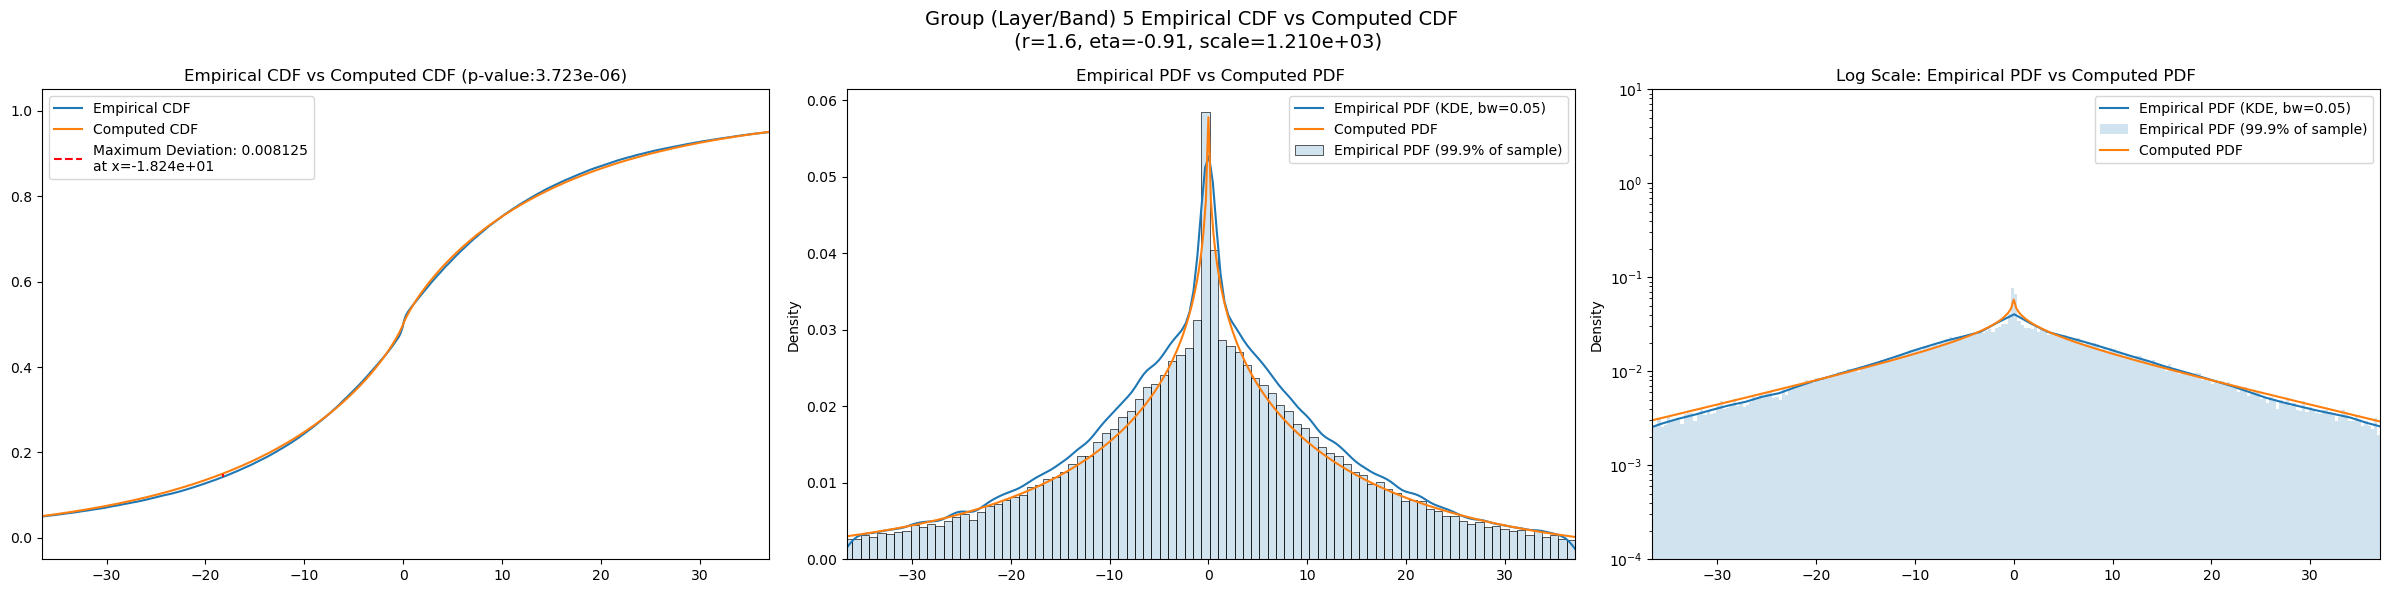

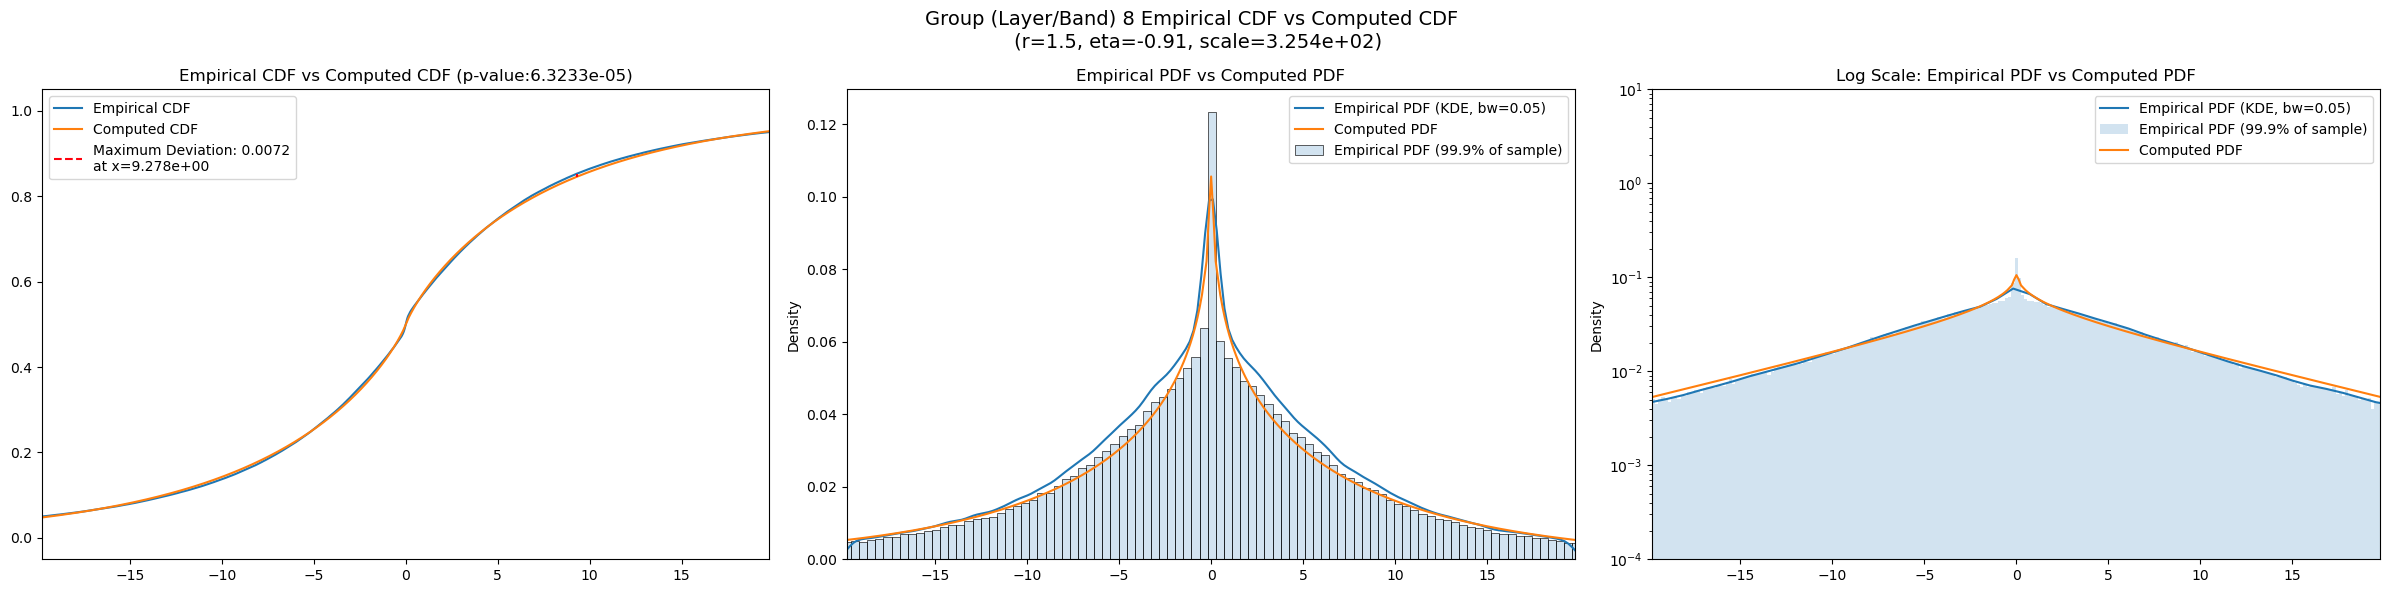

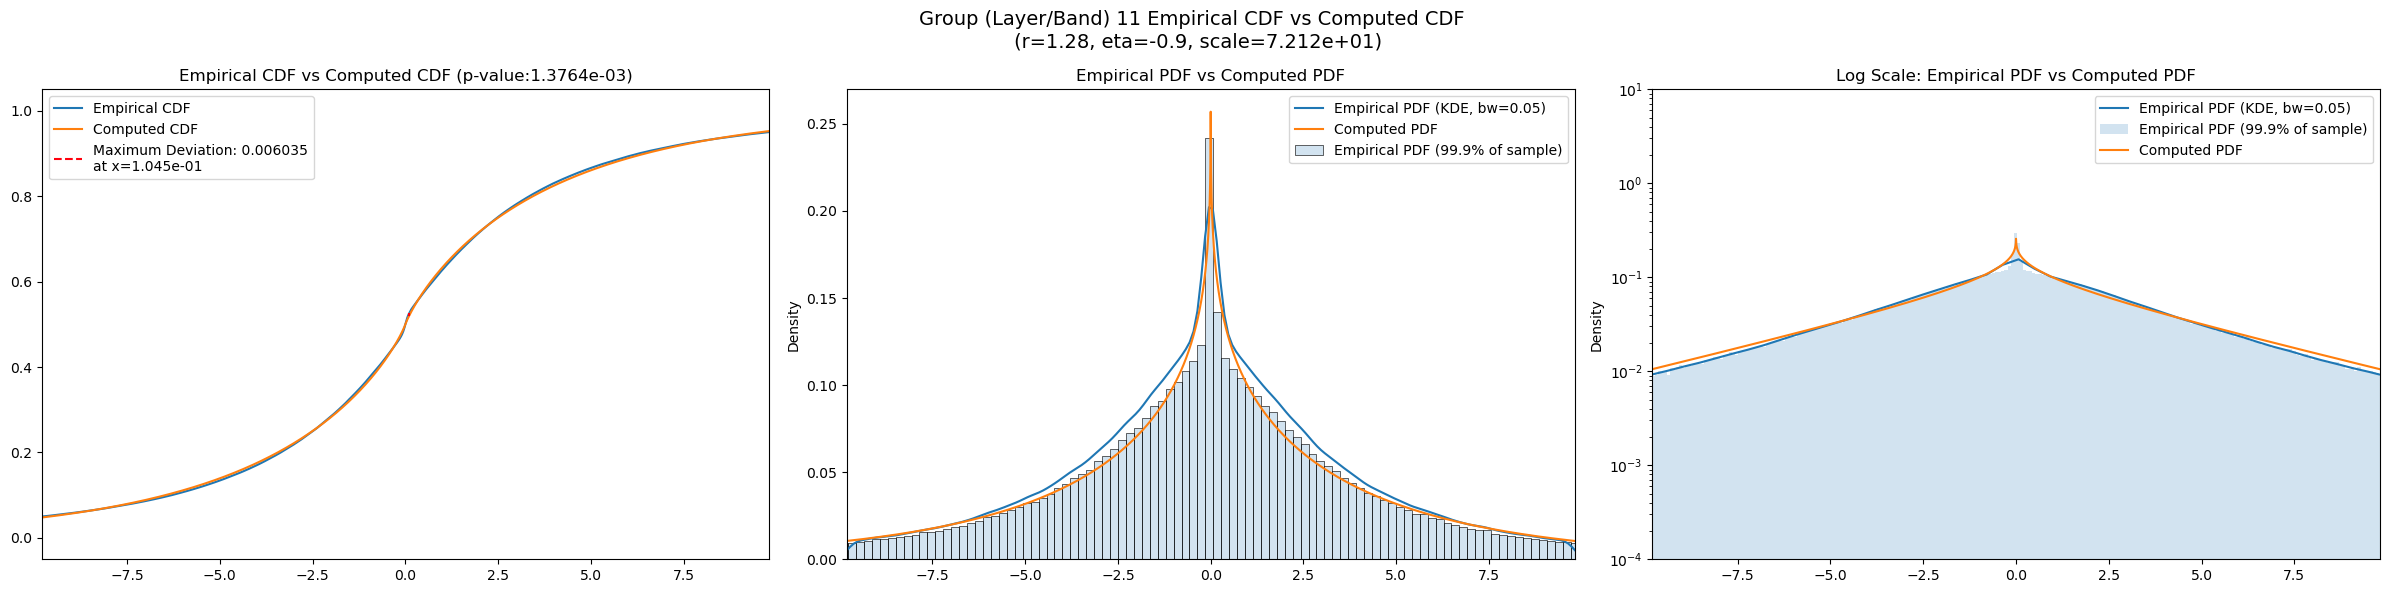

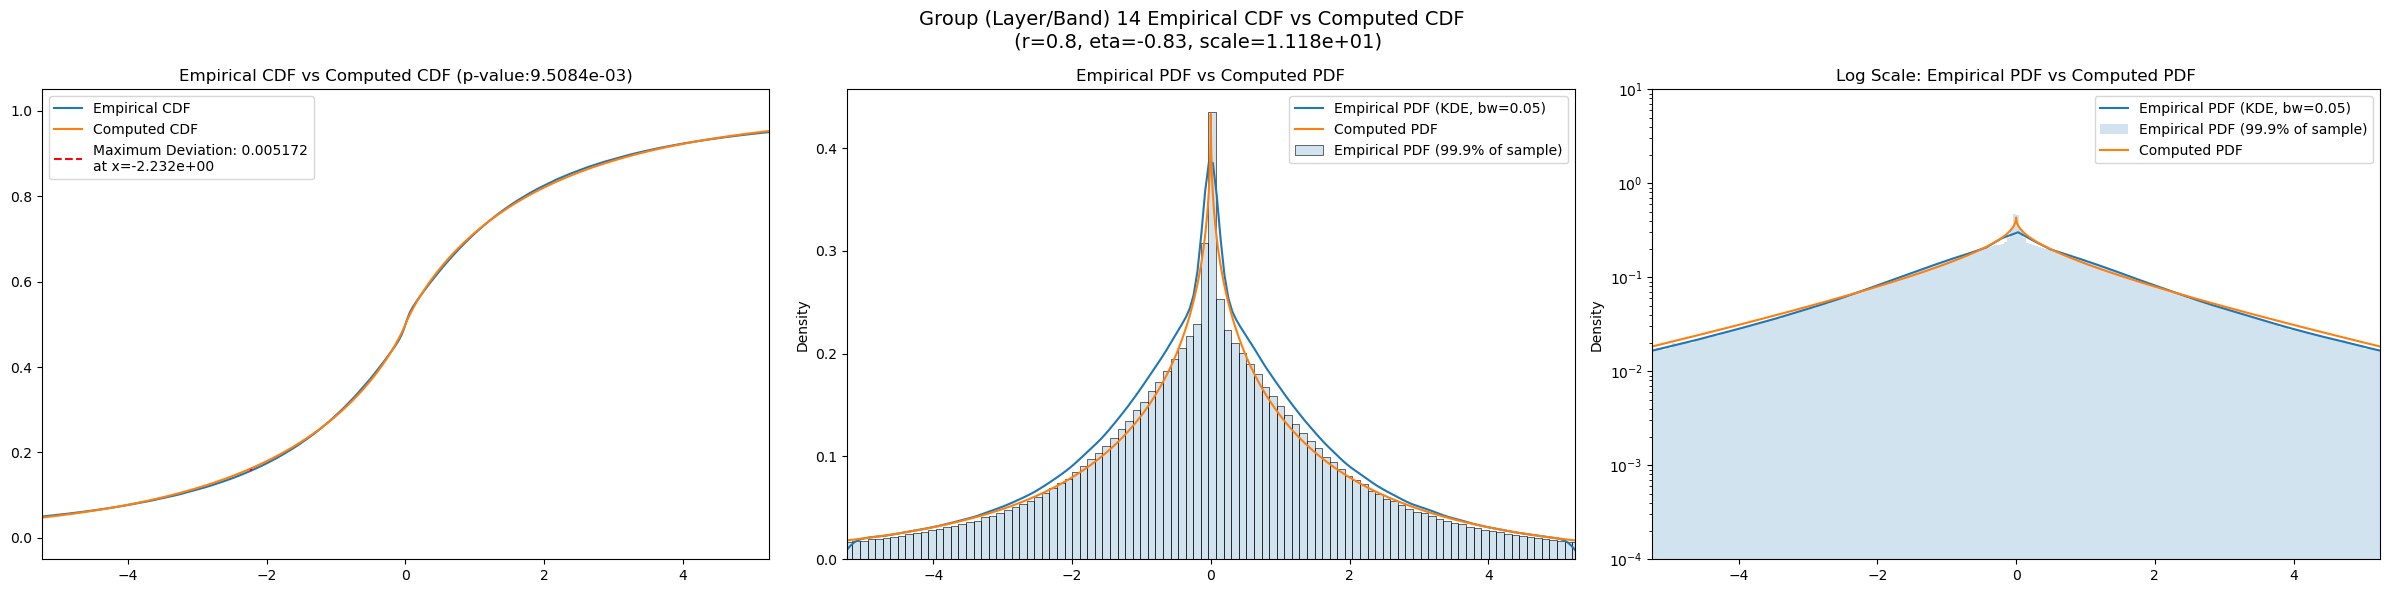

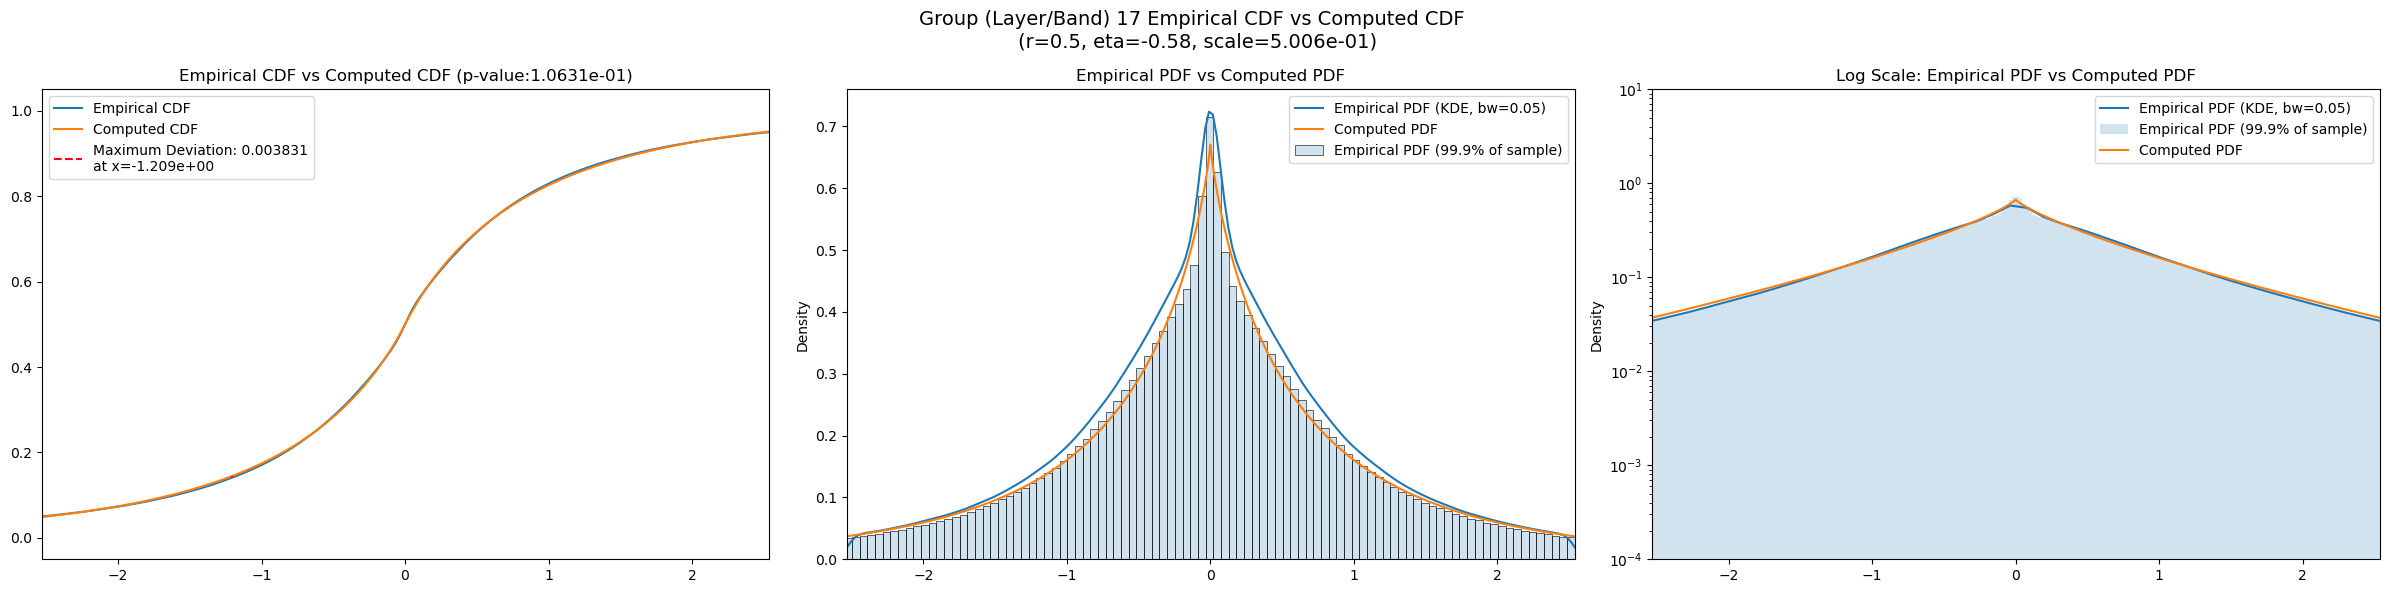

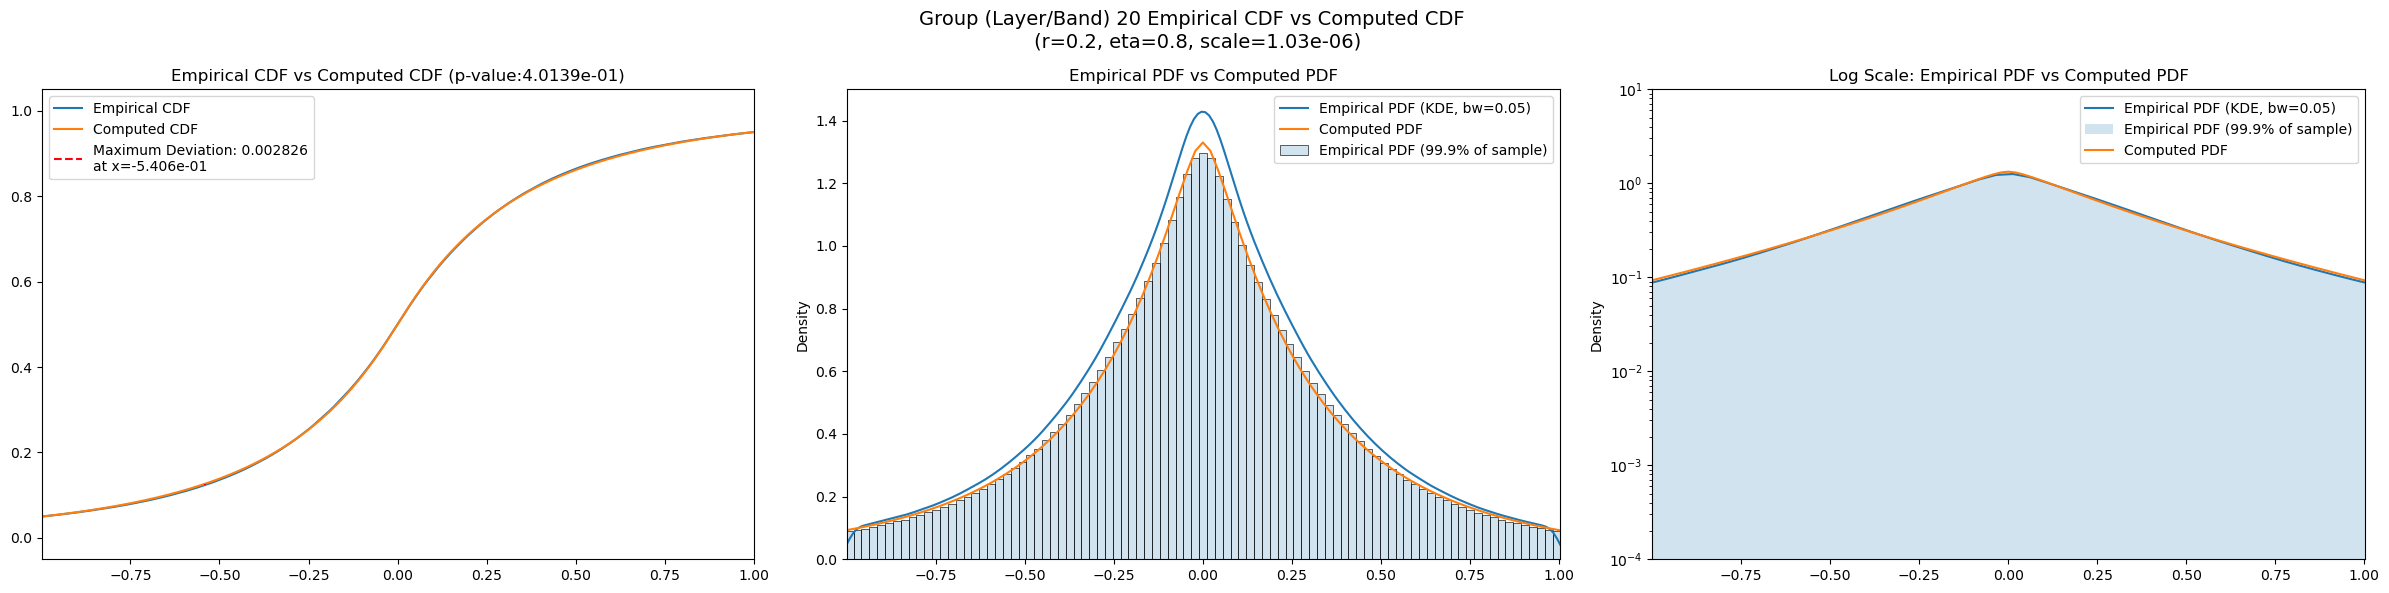

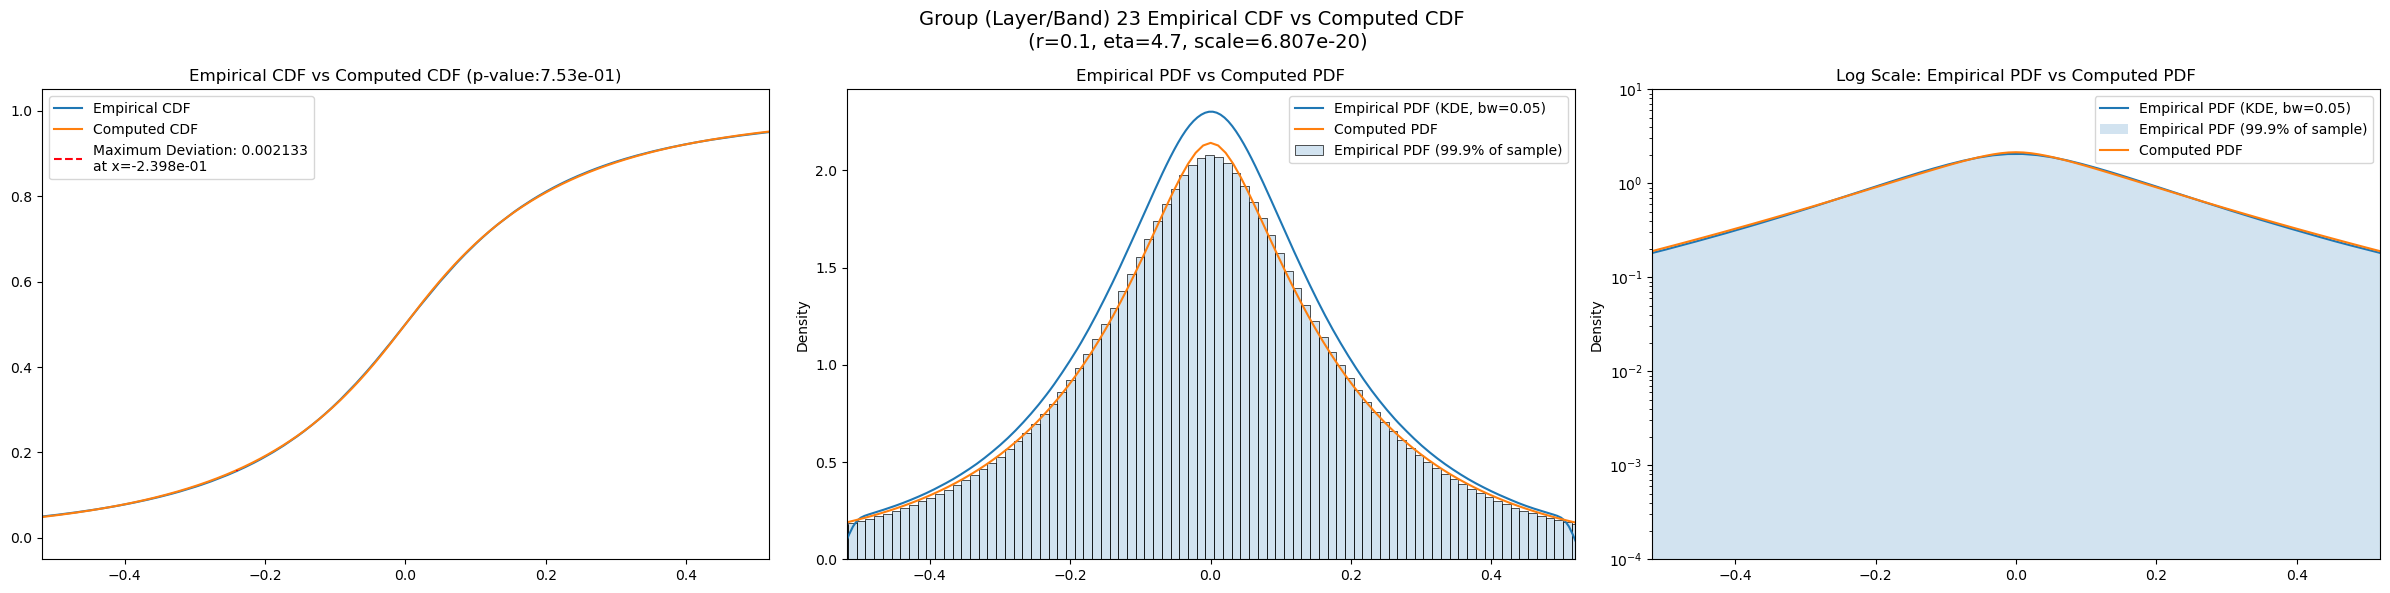

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1477.698100  1373.122700  1589.910200    6.120176    4.479359   
5      613.399660   560.564640   673.379900   10.624530    6.559845   
8      177.002720   161.604260   194.477400   10.694184    6.562629   
11      42.975640    39.382267    46.911724    9.706752    6.305946   
14      12.346855    11.270123    13.649725   11.606633    6.602531   
17       3.035616     2.715409     3.793729   39.583656    7.279816   
20       0.497308     0.429553     0.781897  156.664100    7.438475   
23       0.120288     0.109068     0.150540   34.890343    5.196195   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.864679        47614.0             0.006656        2.7         -0.9   
5      16.423002       102030.0             0.008013        1.4         -0.9   
8      22.191257       326496.0             0.007033        1.4         -0.9   
11     16.889559       904666.0             0.006211        1.3         -0.9   
14     31.444622      2727602.0             0.005579        0.7         -0.8   
17    243.687730      8298440.0             0.004288        0.5         -0.6   
20    791.245600     25140192.0             0.002453        0.2          0.8   
23    215.311260     65734528.0             0.002455        0.1          4.7   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       28.034100              0.034575          6.901960e-50   
5     ...       16.772200              0.038219         6.259220e-130   
8     ...        8.842690              0.038775          0.000000e+00   
11    ...        4.344190              0.039471          0.000000e+00   
14    ...        2.253560              0.042106          0.000000e+00   
17    ...        1.102110              0.041110          0.000000e+00   
20    ...        0.449737              0.037942          0.000000e+00   
23    ...        0.248234              0.032121          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         23.452000             0.012672         4.524200e-07  19.637300   
5         14.107800             0.014574         2.975260e-19  11.548900   
8          7.585790             0.013815         1.466720e-54   6.095590   
11         3.761170             0.014177        2.277730e-158   2.989880   
14         1.987380             0.015265         0.000000e+00   1.549270   
17         0.973782             0.014354         0.000000e+00   0.760192   
20         0.397016             0.012037         0.000000e+00   0.315896   
23         0.215778             0.007873         0.000000e+00   0.176172   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017222   1.068860e-12          2.928566e-02  
5          0.018037   2.891270e-29          6.598533e-06  
8          0.016596   1.510430e-78          9.216572e-14  
11         0.016614  2.498560e-217          5.383226e-29  
14         0.017540   0.000000e+00          3.056525e-62  
17         0.016146   0.000000e+00          1.245211e-93  
20         0.010281   0.000000e+00         8.748086e-132  
23         0.004512   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006656                 0.006220          0.006656   
5                0.008013                 0.004250          0.007863   
8                0.007033                 0.002376          0.006857   
11               0.006211                 0.001428          0.006030   
14               0.005579                 0.000822          0.005108   
17               0.004288                 0.000471          0.003596   
20               0.002453                 0.000271          0.002453   
23               0.002455                 0.000168          0.002455   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.034575             0.012672       0.017222  
5                 0.038219             0.014574       0.018037  
8                 0.038775             0.013815       0.016596  
11                0.039471             0.014177       0.016614  
14                0.042106             0.015265       0.017540  
17                0.041110             0.014354       0.016146  
20                0.037942             0.012037       0.010281  
23                0.032121             0.007873       0.004512

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2            1293.183200          0.006656    2.70     -0.90  3.525249e+03   
5             503.584534          0.007863    1.60     -0.91  1.210222e+03   
8             139.662674          0.006857    1.50     -0.91  3.253503e+02   
11             34.601685          0.006030    1.28     -0.90  7.212481e+01   
14             10.344963          0.005108    0.80     -0.83  1.118454e+01   
17              2.616078          0.003596    0.50     -0.58  5.006274e-01   
20              0.449234          0.002453    0.20      0.80  1.029985e-06   
23              0.114054          0.002455    0.10      4.70  6.806961e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
5                   250.0  
8                   350.0  
11                  325.0  
14                  225.0  
17                  125.0  
20                   25.0  
23                   25.0

In [21]:
eng.quit()